In [21]:
pip install noisereduce

  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import tensorflow as tf
import random
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Normalization, Dropout

from pydub import AudioSegment, effects
from keras import callbacks 



import librosa
import noisereduce as nr


In [3]:
fileList = {}
emotionClass = {
    "Happy": 0,
    "Angry": 1,
    "Suprised": 2,
    "Sad": 3,
    "Fearful": 4,
    "Neutral": 5,
    "Disgusted": 6,
}
# KAGGLE ===================
# BASE_PATH = '/kaggle/input/audio-emotions/Emotions/'
# for emotion in os.listdir(BASE_PATH):
#     fileList[emotion] = []
#     for file in os.listdir(f"{BASE_PATH}/{emotion}"):
#         fileList[emotion].append(f"{BASE_PATH}{emotion}/{file}")

for emotion in os.listdir("./archive/Emotions"):
    fileList[emotion] = []
    counter = 0
    for file in os.listdir(f"{"./archive/Emotions"}/{emotion}"):
        fileList[emotion].append(f"{"./archive/Emotions/"}{emotion}/{file}")
        counter += 1
        if counter > 40: break

In [4]:
for k, v in fileList.items():
    print(f"{k:10s} ==> {len(v)}")

# Lee el archivo WAV
sample_rate, data = wavfile.read(fileList["Neutral"][5])

Happy      ==> 41
Angry      ==> 41
Suprised   ==> 41
Sad        ==> 41
Fearful    ==> 41
Neutral    ==> 41
Disgusted  ==> 41


In [92]:
dataRaw = []
max_length = -1
mfcc_number = 13
index = -1
counter = 0

rms = []
zcr = []
mfcc = []
emotions = []

# Max length of all samples
for emotion, filePath in fileList.items():
    for file in filePath:
        data = AudioSegment.from_file(file)
        data_np = np.array(data.get_array_of_samples(), dtype = 'float32')
        if data_np.shape[0] > max_length: max_length = data_np.shape[0] 
        
print(max_length)

# Features
for emotion, filePath in fileList.items():
    for file in filePath:
        _, sr   = librosa.load(file)
        data = AudioSegment.from_file(file)
        data = effects.normalize(data, headroom = 0) 
        data_np = np.array(data.get_array_of_samples(), dtype = 'float32')
        xt, index = librosa.effects.trim(data_np, top_db=30)
        padded = np.pad(xt, (0, max_length-len(xt)), 'constant')
        data_np = nr.reduce_noise(padded, sr=sr)

        rms_feature = librosa.feature.rms(y=data_np)   
        zcr_feature = librosa.feature.zero_crossing_rate(data_np, center=True)   
        mfcc_feature = librosa.feature.mfcc(y=data_np, sr=sr, n_mfcc=13)

        rms.append(rms_feature)
        zcr.append(zcr_feature)
        mfcc.append(mfcc_feature)

        emotions.append(emotionClass[emotion])

#         mfcc    = librosa.feature.mfcc(y=y, n_mfcc=mfcc_number, sr=sr)
#         mfcc = mfcc.T


#         dataRaw.append(
#             (
#                 # spectrogram_data,
#                 mfcc,
#                 [emotionClass[emotion]],
#             )
#         )

#         counter += 1

#         if np.shape(mfcc)[0] > max_length:
#             max_length = np.shape(mfcc)[0]
#             index = counter

# X = list(list(zip(*dataRaw))[0])
# Y = list(list(zip(*dataRaw))[1])
# Y = to_categorical(Y, num_classes=7)

# for index, element in enumerate(X):
#     original_shape = np.shape(element)[0]
#     array_zeros = np.zeros((max_length, mfcc_number))
#     array_zeros[:original_shape, :] = element
#     X[index] = array_zeros

# np.concatenate(X, axis=0)
# X = np.array(X)
# print(X.shape, Y.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

237037


In [97]:
len(rms)

287

In [98]:
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

In [99]:
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [51]:
X.shape

(287, 463, 15)

In [52]:
reshapedY = np.zeros((X.shape[0], X.shape[1],7))
for i in range(0, X.shape[0]):
    for j in range(0, X.shape[1]):
        reshapedY[i][j] = Y[i]
        

In [111]:
print(X.shape)
print(reshapedY.shape)

(287, 463, 15)
(287, 463, 7)


In [107]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 7)
y_val_class = tf.keras.utils.to_categorical(y_val, 7)

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, reshapedY, random_state=42)

In [109]:
reshapedY = np.zeros((X.shape[0], X.shape[1],7))
for i in range(0, X.shape[0]):
    for j in range(0, X.shape[1]):
        reshapedY[i][j] = Y[i]
        

In [114]:
print(np.shape(X))
print(np.shape(reshapedY))


(287, 463, 15)
(287, 463, 7)


In [116]:
# Definir el modelo
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1:3]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Mostrar resumen del modelo
model.summary()

mcp_save = callbacks.ModelCheckpoint("./file.keras", save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

history = model.fit(X, reshapedY, epochs=100, batch_size=23, shuffle=False)

# model.fit(X_train, Y_train, epochs=40, batch_size=32, shuffle=True)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 463, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 463, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 463, 7)         │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,959 (210.78 KB)

 Trainable params: 53,959 (210.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - categorical_accuracy: 0.0937 - loss: 22.7341
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - categorical_accuracy: 0.0000e+00 - loss: 25.6830
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - categorical_accuracy: 0.0000e+00 - loss: 27.7535
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - categorical_accuracy: 0.0000e+00 - loss: 28.5291
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - categorical_accuracy: 0.0000e+00 - loss: 28.7826
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - categorical_accuracy: 0.0000e+00 - loss: 28.8172
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - categorical_accuracy: 0.0000e+00 - loss: 28.7536
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - categorical_accuracy: 0.0000e+00 - loss: 28.6448
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - categorical_accuracy: 0.0000e+00 - loss: 28.5110
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - categorical_

KeyboardInterrupt: 

In [66]:
print(history)

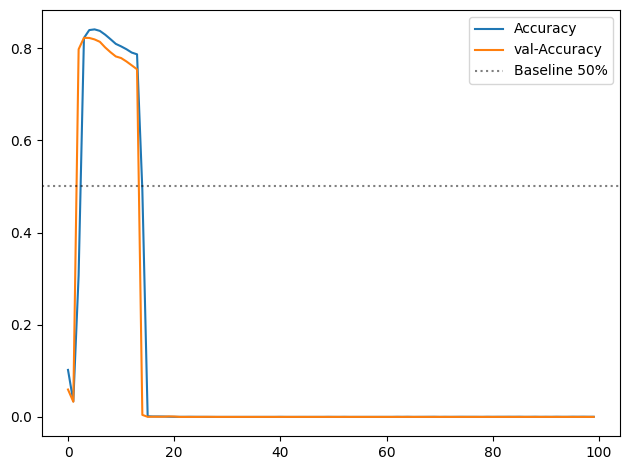

In [75]:

plt.plot(history.history['categorical_accuracy'], label='Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val-Accuracy')
plt.axhline(1/2, c='black', alpha=0.5, linestyle='dotted', label='Baseline 50%')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
a = X_train[0]
print(type(a))
prediction = model.predict(X_train[30:31])

<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [159]:
prediction[0][:, 0].shape

(213,)

In [78]:
import matplotlib
import matplotlib.pyplot as plt


In [1]:
plt.plot(prediction[0][:, 0], label=list(emotionClass.keys())[list(emotionClass.values()).index(0)])
plt.plot(prediction[0][:, 1], label=list(emotionClass.keys())[list(emotionClass.values()).index(1)])
plt.plot(prediction[0][:, 2], label=list(emotionClass.keys())[list(emotionClass.values()).index(2)])
plt.plot(prediction[0][:, 3], label=list(emotionClass.keys())[list(emotionClass.values()).index(3)])
plt.plot(prediction[0][:, 4], label=list(emotionClass.keys())[list(emotionClass.values()).index(4)])
plt.plot(prediction[0][:, 5], label=list(emotionClass.keys())[list(emotionClass.values()).index(5)])
plt.plot(prediction[0][:, 6], label=list(emotionClass.keys())[list(emotionClass.values()).index(6)])

plt.legend(title="Ha")
plt.show()

NameError: name 'plt' is not defined